In [183]:
import pickle
import os
import re
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
from collections import Counter
import math
import matplotlib.pyplot as plt
import random
import json
import datetime
import string
string.punctuation += '➡•’'
import numpy as np
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib
import spacy

In [185]:
nlp=spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

In [186]:
# sp_tokens = ['de', 'la', 's', 'm', 'las', 'los', 'p', 've', 'en', 're', 'del', 't', 'que' ]

In [187]:
dem = pickle.load(open('../../data/all_tweet_texts_dem.p', 'rb'))
rep = pickle.load(open('../../data/all_tweet_texts_rep.p', 'rb'))
bg = pickle.load(open('../../data/moe_sample_tweets.p', 'rb'))

In [316]:
def merge_covid(t):
    if 'COVID' in t or 'coronavirus' in t or 'Coronavirus' in t:
        return 'COVID19'
    else:
        return t

In [365]:
def get_monthly_data(month):
    if month == 'feb':
        dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 2, 1)) & (dem['Time'] < datetime.datetime(2020, 3, 1))]
        rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 2, 1)) & (rep['Time'] < datetime.datetime(2020, 3, 1))]
        bg_month = pickle.load(open('../../data/moe_sample_tweets_feb.p', 'rb'))
    elif month == 'mar':
        dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 3, 1)) & (dem['Time'] < datetime.datetime(2020, 4, 1))]
        rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 3, 1)) & (rep['Time'] < datetime.datetime(2020, 4, 1))]
        bg_month = pickle.load(open('../../data/moe_sample_tweets_mar.p', 'rb'))

    elif month == 'apr':
        dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 4, 1)) & (dem['Time'] < datetime.datetime(2020, 5, 1))]
        rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 4, 1)) & (rep['Time'] < datetime.datetime(2020, 5, 1))]
        bg_month = pickle.load(open('../../data/moe_sample_tweets_apr.p', 'rb'))
    else:
        print('month must be feb, mar, or apr')
    return dem_month, rep_month, bg_month

In [416]:
month = 'apr'

In [417]:
dem_month, rep_month, bg_month = get_monthly_data(month)

In [418]:
print(len(dem_month), len(rep_month), len(bg_month))

54386 35520 113864


In [419]:
dem_month = dem_month.sample(len(rep_month))

In [420]:
def preprocess_text(dem, rep, bg):
    dem = dem.Text.tolist()
    dem = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in dem]
    dem_tokenized = [token.text for t in dem for token in nlp(t)]
    dem_tokenized = [merge_covid(t) for t in dem_tokenized]
    rep = rep.Text.tolist()
    rep = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in rep]
    rep_tokenized = [token.text for t in rep for token in nlp(t)]
    rep_tokenized = [merge_covid(t) for t in rep_tokenized]
    bg = bg.Text.tolist()
    bg = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in bg]
    bg_tokenized = [token.text for t in bg for token in nlp(t)]
    bg_tokenized = [merge_covid(t) for t in bg_tokenized]

    dem_counter=  Counter(dem_tokenized)
    rep_counter= Counter(rep_tokenized)
    bg_counter = Counter(bg_tokenized)
    return dem_counter, rep_counter, bg_counter

In [421]:
dem_counter, rep_counter, bg_counter = preprocess_text(dem_month, rep_month, bg_month)

In [422]:
len(bg_counter), len(dem_counter), len(rep_counter)

(216574, 38825, 37973)

In [423]:
dem_counter['COVID19']

7333

In [424]:
rep_counter['COVID19']

7245

In [425]:
bg_counter['COVID19']

122239

In [426]:
def logodds(corpora_dic, bg_counter):
    """ It calculates the log odds ratio of term i's frequency between 
    a target corpus and another corpus, with the prior information from
    a background corpus. Inputs are:
    
    - a dictionary of Counter objects (corpora of our interest)
    - a Counter objects (background corpus)
    
    Output is a dictionary of dictionaries. Each dictionary contains the log 
    odds ratio of each word. 
    
    """
    corp_size = dict([(c, sum(corpora_dic[c].values())) for c in corpora_dic])
    bg_size = sum(bg_counter.values())
    result = dict([(c, {}) for c in corpora_dic])
    
    for name, c in corpora_dic.items():
        for word in c:
            #if 10 > sum(1 for corpus in corpora_dic.values() if corpus[word]):
            #    continue
            
            fi = c[word]
            fj = sum(co[word] for x, co in corpora_dic.items() if x != name)
            fbg = bg_counter[word]+0.0001
            ni = corp_size[name]
            nj = sum(x for idx, x in corp_size.items() if idx != name)
            nbg = bg_size
#             print(fi+fbg,ni+nbg-(fi+fbg),fj+fbg,nj+nbg-(fj+fbg))
            oddsratio = math.log(fi+fbg) - math.log(ni+nbg-(fi+fbg)) -\
                        math.log(fj+fbg) + math.log(nj+nbg-(fj+fbg))
            std = 1.0 / (fi+fbg) + 1.0 / (fj+fbg)
            z = oddsratio / math.sqrt(std)
            result[name][word] = z
            
    return result

In [427]:
result = logodds({'Republican_tweets': rep_counter, 'Democratic_tweets': dem_counter}, bg_counter)

In [428]:
for k in sorted(result['Republican_tweets'], key=result['Republican_tweets'].get, reverse=True)[0:20]:
    print(result['Republican_tweets'][k], k)

22.939682356901372 Paycheck
22.650859640968726 PaycheckProtectionProgram
21.914939365906207 Protection
20.81795246273176 Program
16.887186754656636 WhiteHouse
16.72257503880366 PPP
15.976603881471604 businesses
14.350549119699938 small
13.635332072764099 Pelosi
13.303558290182055 GOPLeader
12.447586327101705 Ohio
11.969499703127488 Democrats
11.395465405556543 loans
11.06351902872167 realDonaldTrump
10.822746529943474 la
10.513343994015006 de
10.158391124109164 HouseGOP
9.981882022717095 USTreasury
9.936746531953537 →
9.817519874094424 🚨


In [429]:
for k in sorted(result['Democratic_tweets'], key=result['Democratic_tweets'].get,reverse=True)[0:20]:
    print(result['Democratic_tweets'][k], k)

15.595583500836074 LouisianaGov
12.230796411928255 HouseDemocrats
9.986727746413386 EarthDay
9.985725162747634 health
9.964486446083159 2020Census
8.602963805885052 disparities
8.457590905487546 unemployment
8.457020678665883 Trump
8.387018760023116 Jersey
8.056741754738683 need
7.967536987691382 GregHilburn1
7.925154751536739 HispanicCaucus
7.8483294251089335 Nevada
7.766460964779356 USPS
7.659228403562022 Ramadan
7.618881394673773 –
7.611403342888639 Census2020
7.262832085205064 must
7.242820814393724 hall
7.220786119888812 SNAP


In [430]:
from numpy import interp

def plot_logodds(results, group1_name, group2_name, month, num_words=15):
    # the two groups of interest
    dic = results[group1_name]
    # sort to get the most over-represented and under-represented
    group1_overrep_keys = sorted(dic, key=dic.get, reverse=True)[0:num_words]
    group1_overrep_values = [dic[k] for k in group1_overrep_keys]
    group2_overrep_keys = sorted(dic, key=dic.get)[0:num_words]
    group2_overrep_values = [dic[k] for k in group2_overrep_keys]

    blue_minima = min(group2_overrep_values)
    blue_maxima = max(group2_overrep_values)
    blue_norm = matplotlib.colors.Normalize(vmin=blue_minima, vmax=blue_maxima, clip=True)
    blue_mapper = cm.ScalarMappable(norm=blue_norm, cmap=cm.Blues)
    
    red_minima = min(group1_overrep_values)
    red_maxima = max(group1_overrep_values)
    red_norm = matplotlib.colors.Normalize(vmin=red_minima-10, vmax=red_maxima, clip=True)
    red_mapper = cm.ScalarMappable(norm=red_norm, cmap=cm.Reds)
                    
    fig, ax = plt.subplots(1,1, figsize=(14,10))
    text1 = [ax.text(group1_overrep_values[idx], random.random(), group1_overrep_keys[idx],
                     c=red_mapper.to_rgba(group1_overrep_values[idx]), fontsize=13) for idx in range(num_words)]
    text2 = [ax.text(group2_overrep_values[idx], random.random(), group2_overrep_keys[idx],
                     c=blue_mapper.to_rgba(group2_overrep_values[idx]), fontsize=13) for idx in range(num_words)]             

    line = ax.plot([0,0], [0,1], c='black')
    ax.set_xlim(min(group2_overrep_values)-5, max(group1_overrep_values)+5)
    ax.set_ylim(0,1)
    ax.yaxis.set_ticks([])
    ax.set_xlabel('Log odds ratio', fontsize=15)
    ax.set_ylabel('Demoratic overrep words', fontsize=15)
    ax2 = ax.twinx()
    ax2.set_ylabel('Republican overrep words', fontsize=15)
    if month == 'feb':
        ax.set_title('February 2020', fontsize=15)
    elif month == 'mar':
        ax.set_title('March 2020', fontsize=15)
    elif month == 'apr':
        ax.set_title('April 2020', fontsize=15)
    adjust_text(text1+text2, expand_text=(1.01, 1.01), force_text=(0.75, 0.75), add_objects=line, lim=20)
    plt.savefig('logodds_{}.png'.format(month), format='png')

/l/nx/user/jingy/anaconda3/envs/py37tf/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/l/nx/user/jingy/anaconda3/envs/py37tf/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0, flags=flags)


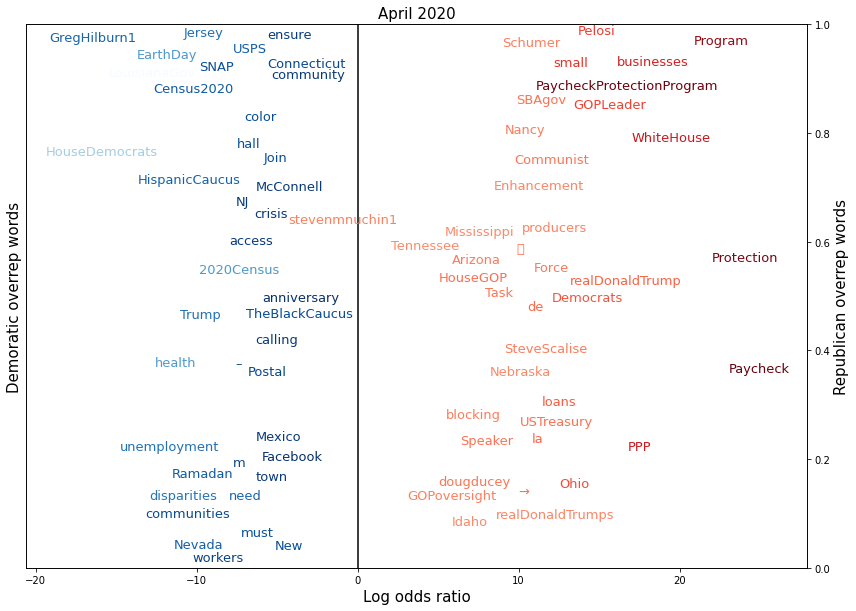

In [431]:
plot_logodds(result, 'Republican_tweets', 'Democratic_tweets', month, num_words=40)